# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.calibration import *
from src.transform import *
from src.threshold import *
from src.lines import *
from src.plotting import *

In [2]:
calibration = Calibration('camera_cal/', (9, 6))
transform = Transform()
threshold = Threshold()
lines = Lines()

# Functions

# Load Image

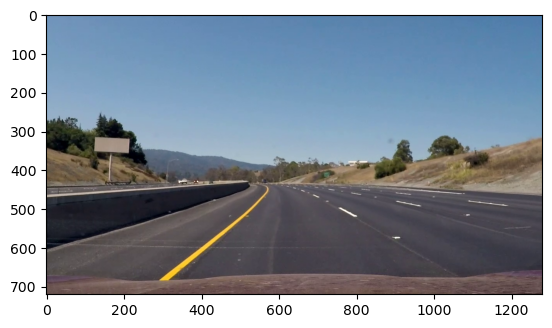

In [3]:
orig_img = cv2.imread('output_media/debug/problem_frames/71_frame.png')
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
plt.imshow(orig_img)

# Remove Image Distortion

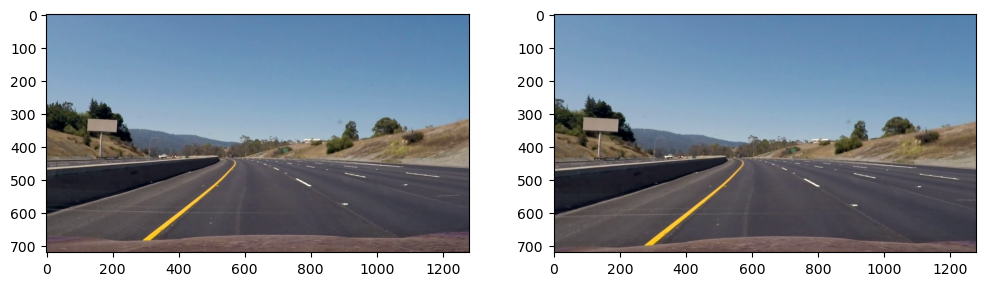

In [4]:
cal_img = calibration.undistort(orig_img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(orig_img)
axs[1].imshow(cal_img)
fig.set_figwidth(12)

plt.show()

# Bird's Eye View

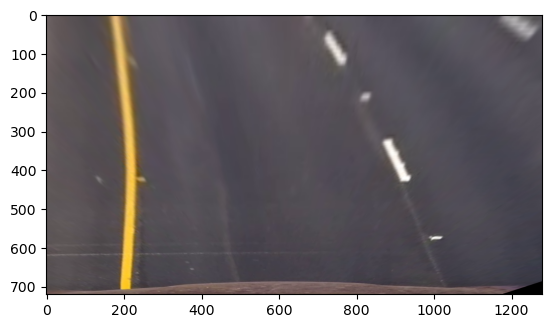

In [5]:
bev_img = transform.orig_to_bev(cal_img)
plt.imshow(bev_img)

# Thresholding

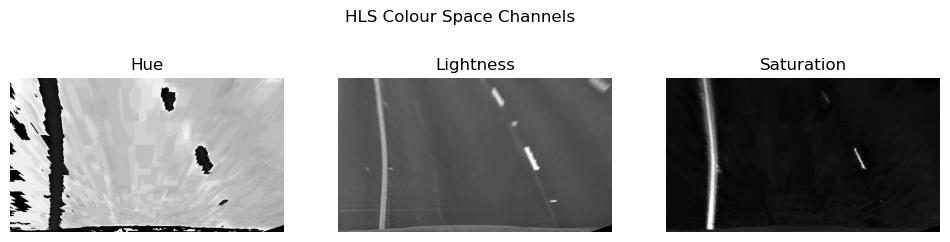

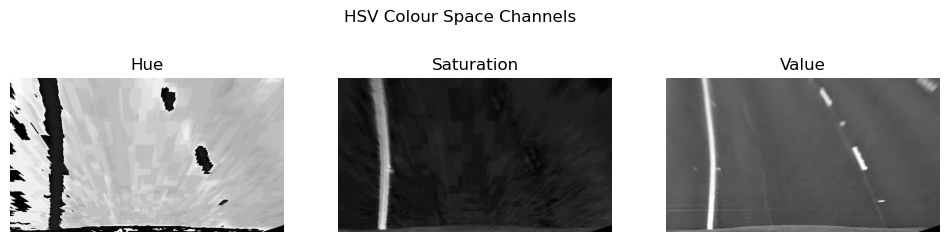

In [6]:
hls = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HSV)

hls_dict = {
    'Hue' : hls[:,:,0],
    'Lightness' : hls[:,:,1],
    'Saturation' : hls[:,:,2]
}

hsv_dict = {
    'Hue' : hsv[:,:,0],
    'Saturation' : hsv[:,:,1],
    'Value' : hsv[:,:,2]
}

plot_channels(hls_dict, title='HLS Colour Space Channels')
plot_channels(hsv_dict, title='HSV Colour Space Channels')

## Yellow

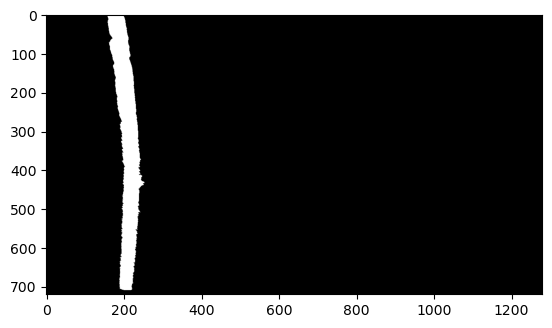

In [7]:
yellow_lower_range = np.array([0, 100, 100])
yellow_upper_range = np.array([50, 255, 255])

yellow = cv2.inRange(hsv, yellow_lower_range, yellow_upper_range)

plt.imshow(yellow, cmap='gray')

## White

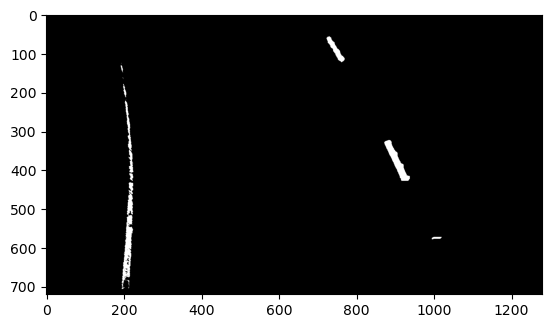

In [8]:
gray = cv2.cvtColor(bev_img, cv2.COLOR_RGB2GRAY)
white_lower_range = np.array([200])
white_upper_range = np.array([255])

white = cv2.inRange(gray, white_lower_range, white_upper_range)
plt.imshow(white, cmap='gray')

## Value

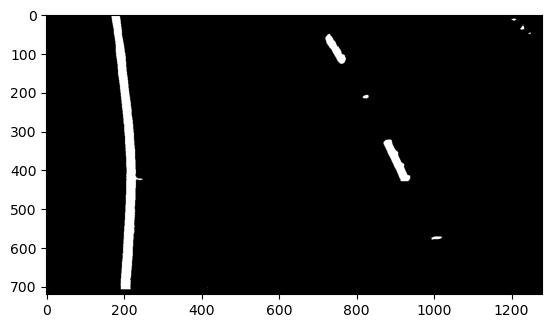

In [9]:
v_channel = hsv_dict['Value']
v_channel_lower_range = np.array([175])
v_channel_upper_range = np.array([255])

value = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)
plt.imshow(value, cmap='gray')

## Relative Thresholding

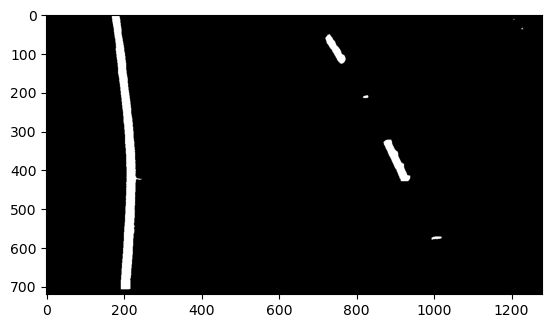

In [10]:
gray_thresh = 125

if np.mean(gray) <= gray_thresh:
    v_channel = hsv_dict['Value']
    v_channel_lower_range = np.array([180])
    v_channel_upper_range = np.array([255])
    relative = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)
else:
    s_channel_lower = np.array([200])
    s_channel_upper = np.array([255])
    relative = cv2.inRange(hls_dict['Saturation'], s_channel_lower, s_channel_upper)

plt.imshow(relative, cmap='gray')

## Adaptive Thresholding

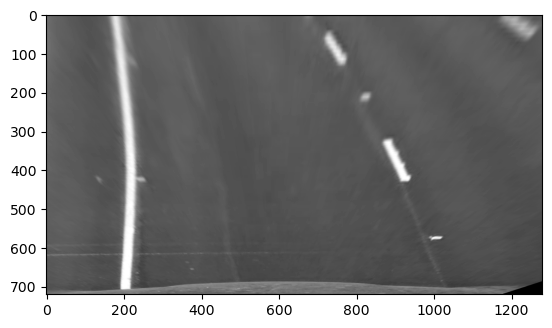

In [11]:
plt.imshow(hsv_dict['Value'],cmap='gray')

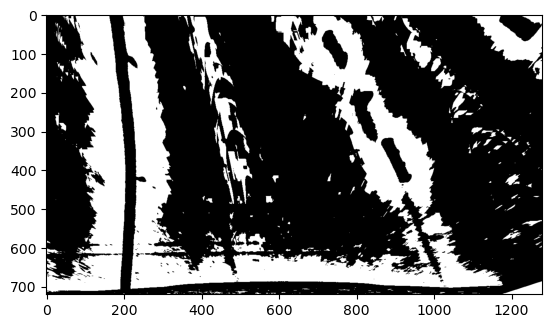

In [12]:
adpt_thresh_1 = cv2.adaptiveThreshold(hls_dict['Lightness'], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 255, 3)
plt.imshow(adpt_thresh_1, cmap='gray')

## Combined Threshold

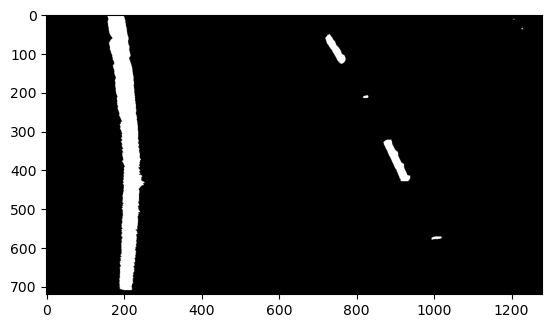

In [13]:
thresh_img = yellow | white | relative
plt.imshow(thresh_img, cmap='gray')

## HLS Thresholding

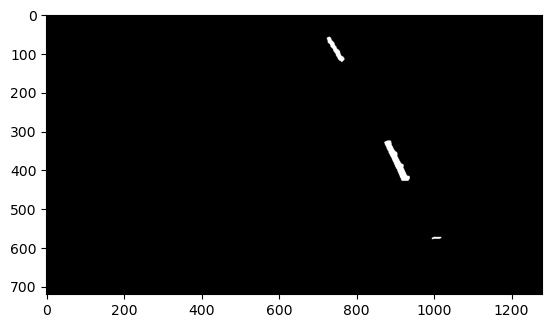

In [14]:
white_lower = np.array([int(0 / 2), int(0.80 * 255), int(0.00 * 255)])
white_upper = np.array([int(360 / 2), int(1.00* 255), int(1.00 * 255)])
white = cv2.inRange(hls, white_lower, white_upper)
plt.imshow(white, cmap='gray')

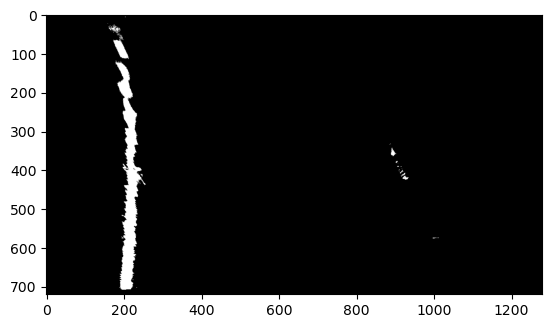

In [15]:
yellow_lower = np.array([int(40 / 2), int(0.20 * 255), int(0.20 * 255)])
yellow_upper = np.array([int(60 / 2), int(1.00* 255), int(1.00 * 255)])
yellow = cv2.inRange(hls, yellow_lower, yellow_upper)
plt.imshow(yellow, cmap='gray')

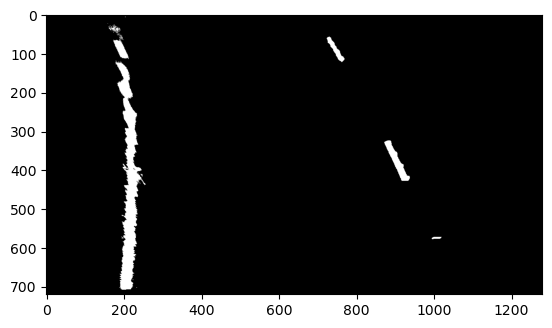

In [16]:
thresh_img = yellow | white
plt.imshow(thresh_img, cmap='gray')

## Inspecting Threshold for Multiple Images

In [17]:
# # Get file names
# fnames = glob("{}/*".format('test_images/'))

# # Create dict to store images
# dict = dict.fromkeys(['original', 'bev', 'yellow', 'white', 'value', 'combined'])

# # Define subplot parameters
# nrows = len(fnames)
# ncols = len(dict)

# # Create figure
# fig, axs = plt.subplots(nrows, ncols, figsize=(12,12))

# # Set title of each column
# for ax, col in zip(axs[0], dict.keys()):
#     ax.set_title(col)

# # Iterate through images and generate threshold images
# for row, file in enumerate(fnames):
#     # Read in image
#     img = cv2.imread(file)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     dict['original'] = img

#     img = calibration.undistort(img)
#     img = transform.orig_to_bev(img)
#     dict['bev'] = img

#     # Get colour spaces
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # Apply colour-specific thresholding
#     dict['yellow'] = cv2.inRange(hsv, yellow_lower_range, yellow_upper_range)
#     dict['white'] = cv2.inRange(gray, white_lower_range, white_upper_range)
#     dict['value'] = cv2.inRange(v_channel, v_channel_lower_range, v_channel_upper_range)

#     # Combine threshold channels
#     dict['combined'] = dict['yellow'] | dict['white'] | dict['value']

#     for col, (title, img) in enumerate(dict.items()):
#         if title in ['original', 'bev']:
#             axs[row, col].imshow(img)
#         else:
#             axs[row, col].imshow(img, cmap='gray')
#         axs[row, col].axis(False)

# fig.tight_layout()
# plt.show()

# Find Lines

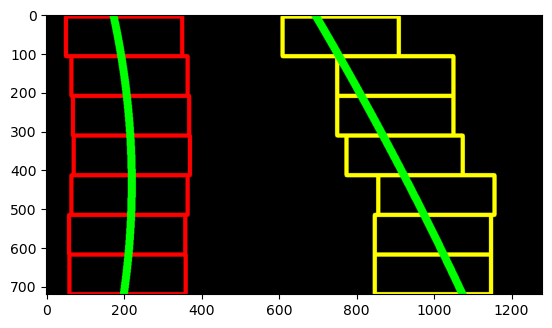

In [18]:
lines_img = lines.sliding_window(thresh_img, draw_boxes=True)
plt.imshow(lines_img)

# Transform to Front View

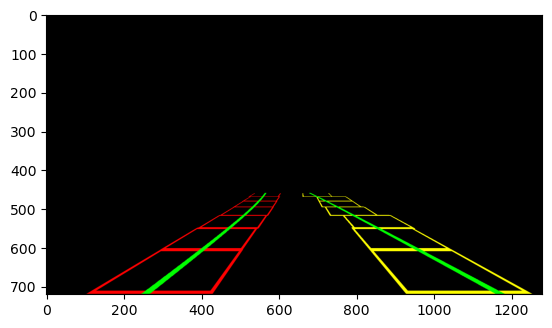

In [19]:
trans_lines_img = transform.bev_to_orig(lines_img)
plt.imshow(trans_lines_img)

# Combine Original Image and Lines

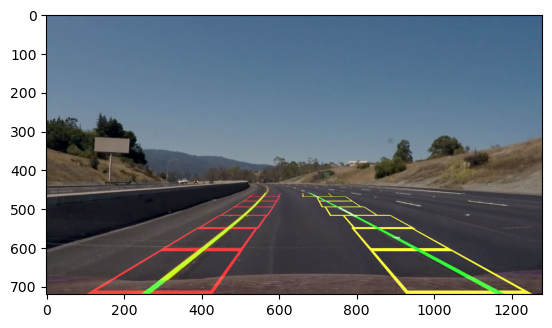

In [20]:
output_img = cv2.addWeighted(orig_img, 0.8, trans_lines_img, 1.0, 0.0)
plt.imshow(output_img)